In [19]:
import sys
import os
import numpy as np
import pandas as pd
import datetime
import tqdm
import pickle
from collections import deque
from math import ceil, sqrt, floor, gamma
from scipy import signal, stats, fftpack 
from sklearn import preprocessing
from keras.models import load_model
from PIL import Image
import multiprocessing as mp
import matplotlib.pyplot as plt
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
# from dataset import Dataset
# from database import Database
from sample import Sample

class SampleDetector(Sample):
    
    def __init__(self, dataset_location, site, file):
        super().__init__(dataset_location, site, file)
    
    ###################################################
    # SIMULATED WHISTLER
    def whistler_sim_full_freq(self, decay, size=25, whistler_time=1.2, whistler_freq_len=7, whistler_freq_start=3):
        time_res, freq_res, freq_len = self.get_time_res(),self.get_freq_res(), len(self.get_freq())
        data = np.full((size,size),0.001)
        x = np.linspace(0,1,size)
        y = np.array([int(np.exp(-decay*_x)*size) for _x in x])
        y[0] -= 1
        x,z = np.array(list(range(size))), np.full(size,1e3)
        for i,j,k in zip(x,y,range(len(z))):
            data[i,j]= z[k]
        data = data.T.astype(np.uint8)
        data = Image.fromarray(data).resize((int(whistler_time/time_res),int(whistler_freq_len/freq_res)),Image.ANTIALIAS)
        data = np.array(data)
        full_data = np.full(( freq_len,int(whistler_time/time_res)),0.001)
        full_data[int(whistler_freq_start/freq_res):int(whistler_freq_start/freq_res)+data.shape[0],:] = data
        return full_data
    
    def whistler_sim(self, decay, size=25, whistler_time=1.2, whistler_freq_len=7, whistler_freq_start=3, thickness=10, freq_slice=[0,20]):
        data = np.full(( len(self.get_freq()),int(whistler_time/self.get_time_res())),0.001)
        for d in np.linspace(0,self.get_freq_res()*thickness,thickness):
            data += self.whistler_sim_full_freq(decay, size, whistler_time, whistler_freq_len, whistler_freq_start+d)
        data = data/thickness
        data = data[int(freq_slice[0]/self.get_freq_res()):int(freq_slice[1]/self.get_freq_res()),:]
        return data
    
    def window(self, signal, window, stride):
        roll = []
        i = 0
        for ix in range(0,len(signal)-window+1,stride):
            roll.append(signal[ix:ix+window])
            i += 1
        return np.array(roll)
    
    def rolling(self, signal, window, stride):
        roll = []
        for ix in range(0,len(signal)-window+1,stride):
            roll.append(signal[ix:ix+window])
        diff = len(signal)-len(roll)
        for ix in range(diff):
            roll.append(np.full(window+1,0))
        roll = np.array(roll)
        roll = np.roll(roll,int(diff/2))
        return roll
    
    def moving_zscore(self, signal, N, G, z_thres=None):
        """Z score of the N+G cell on series of N cells"""
        stride = 1
        threshold = lambda w: (w[N+G]-w[:N].mean())/w[:N].std()
        windows = self.rolling(signal, window=N+G+1, stride=1)
        detector = np.array(list(map(threshold, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
    
    def moving_average(self, signal, N, G):
        """Moving average"""
        average = lambda w: (1)*(((w[:N]).sum()+(w[N+2*G+1:]).sum())/(2*N))
        windows = self.rolling(signal, window=2*(N+G)+1, stride=1)
        detector = np.array(list(map(average, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
    
    def ca_cfar(self, signal, N, G, pfa):
        """Cell Averaging Constant False Alarm Rate (CFAR)"""
        stride=1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        threshold = lambda w: ca*(((w[:N]**2).sum()+(w[N+2*G+1:]**2).sum())/(2*N))
        windows = self.window(signal, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
    
    def goca_cfar(self, signal, N, G, pfa):
        """Greater Of Cell Averaging CFAR """
        stride = 1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        threshold = lambda w: ca*(max((w[:N]**2).mean(),(w[N+2*G+1:]**2).mean()))
        windows = self.window(signal, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
        
    def soca_cfar(self, signal, N, G, pfa):
        """Smaller Of Cell Averaging CFAR"""
        stride = 1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        threshold = lambda w: ca*(min((w[:N]**2).mean(),(w[N+2*G+1:]**2).mean()))
        windows = self.window(signal, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
    
    def tm_cfar(self, signal, N, G, C, pfa):
        """Trimmed Mean Cell Averaging CFAR"""
        stride = 1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        def trim(window):
            w = np.concatenate((window[:N],window[N+2*G+1:]))
            w.sort()
            return w[:2*N-C-1]
        threshold = lambda w: ca*((trim(w)**2).sum()/(2*N-C))
        windows = self.window(signal, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
    
    def apply_detector(self, signal, detector, params):
        """Apply a CFAR detector"""
        if detector=='ca_cfar':
            return self.ca_cfar(signal,N=params[0],G=params[1],pfa=params[2])
        if detector=='soca_cfar':
            return self.soca_cfar(signal,N=params[0],G=params[1],pfa=params[2])
        if detector=='goca_cfar':
            return self.goca_cfar(signal,N=params[0],G=params[1],pfa=params[2])
        if detector=='tm_cfar':
            return self.tm_cfar(signal,N=params[0],G=params[1],pfa=params[2],C=params[3])
    
    def diff(self, signal, window):
        windows = self.rolling(signal, window, 1)
        z = lambda w: (w[int(window/2):].mean()-w[:int(window/2)].mean())
        return np.array(list(map(z, windows)))
    
    def detection_area(self, signal, detector):
        """pulse where signal square is above the threshold"""
        signal_sqrt = signal[detector[1]]**2
        loc_area = np.array([True if sig>thres else False for sig,thres in zip(signal_sqrt,detector[0])])
        loc_area[0], loc_area[-1] = False, False
        return loc_area 
    
    def detection_loc(self, signal, detector, shift):
        """Location of the whistler after detection"""
        signal_sqrt = signal[detector[1]]**2
        detection = np.array([True if sig>thres else False for sig,thres in zip(signal_sqrt,detector[0])])
        detection[0], detection[-1] = False, False
        loc = np.array([x if x>0 else x for x in self.diff(detection, 2)])
        high,low = np.argwhere(loc==1), np.argwhere(loc==-1)
        assert len(high)==len(low)
        ix = []
        for h,l in zip(high, low):
            i = int((h[0]+l[0])/2)+shift 
            i = i if i<len(signal) else len(signal)-1
            r = np.log10(signal[i]**2)
            ix.append([str(i*self.get_time_res()),str(r[0])])
        ix = np.array(ix)
        return ix
    
    
    def detection_area_ml(self, kernel_shape, scaler, model):
        detection, prob = [], []
        freq_len,time_len = kernel_shape
        to_evt = lambda x: 1 if x==1 else 0
        my_spec = self.get_spectrogram()
        for ix in range(my_spec.shape[1]-time_len+1):
            spec = my_spec[:,ix:ix+time_len]
            spec = spec.reshape(1,freq_len*time_len)
            spec = scaler.transform(spec)
            spec = spec.reshape(1,1,freq_len,time_len)
            detection.append(to_evt(np.argmax(model.predict(spec)[0])))
            prob.append(model.predict(spec)[0].max())
        detection = np.array(detection)
        prob = np.array(prob)
        return detection, prob
    
    def detection_loc_ml(self, detection, prob):
        detection[0], detection[-1] = False, False
        loc = np.array([x if x>0 else x for x in self.diff(detection, 2)])
        high,low = np.argwhere(loc==1), np.argwhere(loc==-1)
        assert len(high)==len(low)
        ix = []
        for h,l in zip(high, low):
            i = int((h[0]+l[0])/2)
            i = i if i<len(detection) else len(detection)-1
            ix.append([str(i*self.get_time_res()),str(prob[i])])
        ix = np.array(ix)
        return ix

    def output_compare(self, signal, detector, shift, diff_err, time_err):
        """Compare the proximity of the output using this detector to the awd output"""
        output_awd = self.awda_whistlers(time_err=time_err)
        output_mf = self.awda_whistlers(time_err=time_err,_output=self.detection_loc(signal,detector,shift))
#         output_mf = deque([]) if len(output_mf)==0 else deque(output_mf[0])  
#         output_awd = deque(output_awd[0])
        output_mf = np.array([]) if len(output_mf)==0 else output_mf[0]
        output_awd = output_awd[0]
        output_awd,output_mf=list(output_awd),list(output_mf)
        queue = []
        within_range = lambda out1,out2,err: True if abs(out1-out2)<=err else False
        last_entry = output_awd[-1] 
        end = False
        while(not end):
            for awd, awd_ix in zip(output_awd, range(len(output_awd))):
                for mf, mf_ix in zip(output_mf, range(len(output_mf))):
                    if within_range(awd[0],mf[0],diff_err):
                        queue.append(np.array([mf,0]))
                        del output_awd[awd_ix]
                        del output_mf[mf_ix]
                        break
                else:
                    continue
                break
            if last_entry[0]==awd[0]:
                end=True
        for awd in output_awd:
            queue.append(np.array([awd,-1]))
        for mf in output_mf:
            queue.append(np.array([mf, 1]))
        return np.array(queue)
    
    def metric(self, signal, detector, shift, diff_err, time_err):
        """Give metric of detection"""
        queue = self.output_compare(signal, detector, shift,diff_err, time_err)
        count = np.zeros(3, dtype=np.int)
        for q in queue[:,1]:
            if q==-1:
                count[0]+=1
            elif q==0:
                count[1]+=1
            elif q==1:
                count[2]+=1
        return count
    
    def segmented_correlation(self, transforms, transforms_params, kernel, mode='valid'):
        spec, segments, corr = self.get_spectrogram(), [], []
        nbr_segments = spec.shape[1]-kernel.shape[1]
        for n in range(nbr_segments):
            seg = self.apply_transform(transforms, transforms_params,sig=spec[:,n:n+kernel.shape[1]])
            segments.append(seg)
            corr.append(signal.correlate(10**seg, kernel, mode=mode).T)
        return np.array(segments), np.array(corr).reshape((len(corr),1))
    
    def evaluate_detector(self, transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel,segmented=False):
        if segmented:
            corr = self.segmented_correlation(transforms, transforms_params, kernel,mode='valid')[1]
#             corr = corr.reshape((len(corr),1))
        else:
            self.apply_transform(transforms,transforms_params)
            corr = signal.correlate(10**self.get_spectrogram(), kernel, mode='valid').T
        detector = self.apply_detector(corr,detector, detector_params)
        shift = detector_params[0]+detector_params[1]+int(kernel.shape[1]/3)
#         print(shift)
        return np.array([self.get_file(),self.output_compare(corr,detector,shift=shift, diff_err=diff_err,time_err=time_err), self.metric(corr,detector,shift=shift, diff_err=diff_err,time_err=time_err)])

In [10]:
# fn
# '2013-07-31UT01:46:16.53091914.marion.vr2'

# fp
# '2013-05-28UT14:13:02.78732164.marion.vr2'
# '2013-06-10UT14:34:37.14169609.marion.vr2'
# '2013-06-26UT10:54:31.14851930.marion.vr2'

In [17]:
import sys
import os
import numpy as np
import pandas as pd
import datetime
import tqdm
from collections import deque
from math import ceil, sqrt, floor, gamma
from scipy import signal, stats, fftpack 
from sklearn import preprocessing
from PIL import Image
import multiprocessing as mp
import matplotlib.pyplot as plt
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from sample import Sample
from dataset import Dataset
from database import Database
# from detector import Detector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
my_dataset = Dataset(dataset_loc, site)
my_database = Database(dataset_loc, database_loc, site)
my_sample = SampleDetector(dataset_loc, site, np.random.choice(my_database.get_train(),1)[0])

# file = '2013-07-25UT04:30:47.73731922.marion.vr2'
# file= '2013-06-25UT14:04:42.60451922.marion.vr2'
# file = '2013-01-27UT00:58:07.81987602.marion.vr2'   # use this in research
file = '2013-07-02UT14:23:00.07651914.marion.vr2'
# file = '2013-07-02UT15:03:58.44451914.marion.vr2'
# file = '2013-07-07UT14:34:37.06211914.marion.vr2'
# file = '2013-06-09UT12:52:37.22969609.marion.vr2'
# file = '2013-05-18UT13:22:09.68232156.marion.vr2'
my_sample = SampleDetector(dataset_loc, site,file)

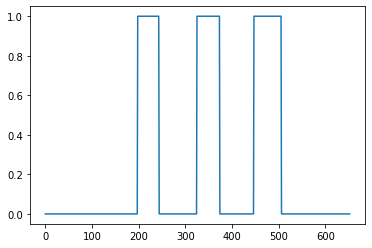

[['1.4070736842105263' '0.9290743']
 ['2.225734736842105' '0.9070047']
 ['3.038' '0.92859596']]


In [20]:
scaler_path = os.path.join(database_loc,site,'scaler.pickle')
model_path = os.path.join(database_loc,site,'model.h5')

my_sample = SampleDetector(dataset_loc, site,file)
my_sample.apply_transform(['slice','zscore'],[[2.5,10],[None]])

detec, prob = my_sample.detection_area_ml(kernel_shape=[48,108],
                       scaler=pickle.load( open( scaler_path, "rb" ) )['scaler'], model=load_model(model_path))
ix = my_sample.detection_loc_ml(detec, prob)
plt.figure();plt.plot(detec);plt.show()
print(ix)

2013-07-02UT14:23:00.07651914.marion.vr2


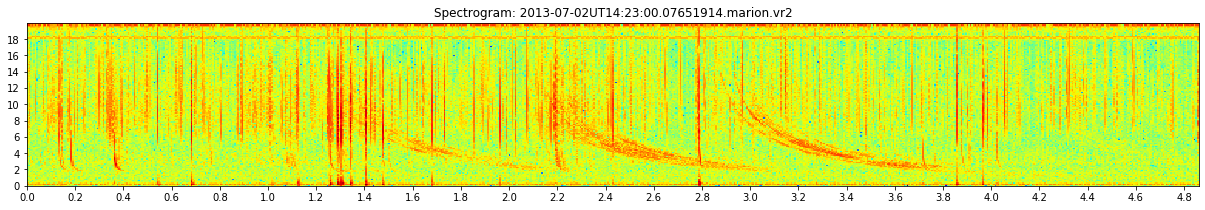

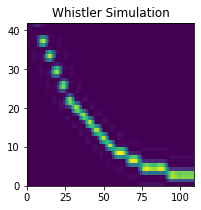

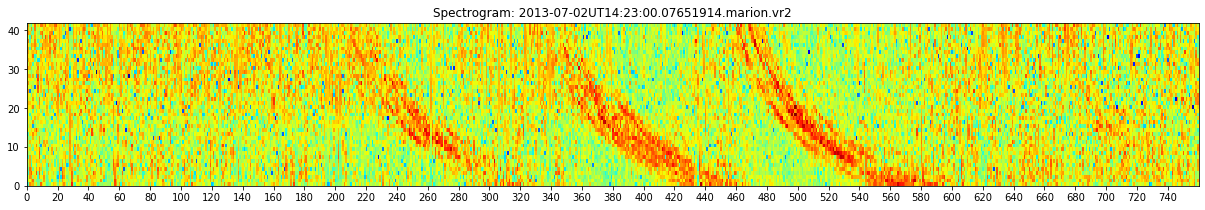

(42, 760) (42, 109)
(652, 1)


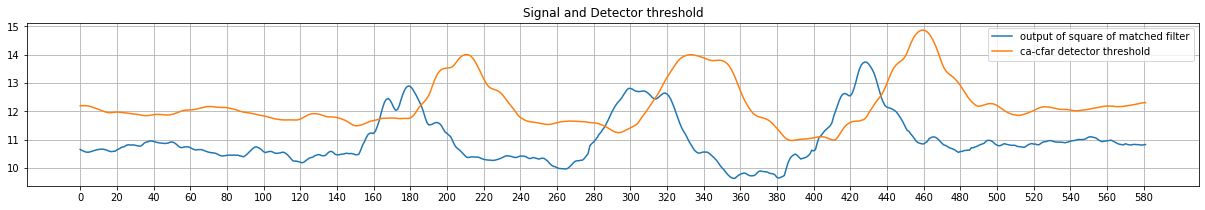

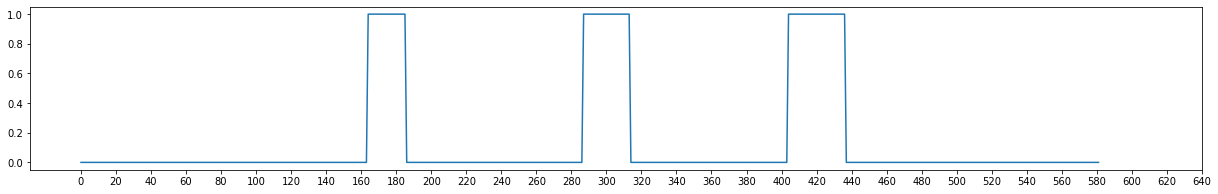

['2013-07-02UT14:23:00.07651914.marion.vr2'
 array([[array([ 1.56696842, 10.4188789 ]), 0],
       [array([ 2.36644211, 10.62639772]), 0],
       [array([ 3.13393684, 11.0292162 ]), 0]], dtype=object)
 array([0, 3, 0])]


In [4]:
my_sample.spectrogram_with_axis(log10=True)
print(my_sample.get_file())
time_err=0.2
diff_err=0.3
freq_size = 3
freq_slice = [2.5,9]
detector, detector_params = 'tm_cfar', [10,25,1e-6,10]
transforms, transforms_params = ['slice','zscore'],[freq_slice,[None]]
size = (freq_size*my_sample.get_time_freq_ratio(dec=0), freq_size)

my_sample.spectrogram_plot(figsize=size, zlabel='sprectrum magnitude [dB]', xaxis=True, yaxis=True, ticks=[0.2,2],
                           title="Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=False)
kernel = my_sample.whistler_sim(decay=3, whistler_time=0.7, whistler_freq_len=7.5, whistler_freq_start=2.5, 
                                thickness=1,size=25,freq_slice=freq_slice)
fig=plt.figure(figsize=(3,int(size[0]*kernel.shape[1]/my_sample.get_spectrogram().shape[1])));img=plt.pcolormesh(kernel);plt.title("Whistler Simulation");plt.show();

my_sample.apply_transform(transforms, transforms_params)
my_sample.spectrogram_plot(figsize=size, zlabel='sprectrum magnitude [dB]', xaxis=False, yaxis=False, ticks=[20,10],
                           title="Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=False)
print(my_sample.get_spectrogram().shape, kernel.shape)
corr = signal.correlate(10**my_sample.get_spectrogram(), kernel, mode='valid').T
print(corr.shape)
detect = my_sample.apply_detector(corr,detector, detector_params)
# print(my_sample.get_spectrogram().shape,kernel.shape,corr.shape)
# plt.figure(figsize=size);plt.plot(corr);plt.xticks(np.arange(0, len(corr), 20));plt.grid();plt.title("Result of Matched Filter");plt.show()
# plt.figure(figsize=size);plt.plot(np.log10(corr**2));plt.xticks(np.arange(0, len(corr), 20));plt.grid();plt.title("Square of Result of Matched Filter");plt.show()
plt.figure(figsize=size)
plt.plot(np.log10(corr[detect[1]]**2))
plt.plot(np.log10(detect[0]))
plt.xticks(np.arange(0, len(detect[1]), 20));plt.grid();
plt.title('Signal and Detector threshold')
plt.legend(['output of square of matched filter', 'ca-cfar detector threshold'])
plt.show()
plt.figure(figsize=size);plt.plot(my_sample.detection_area(corr,detect));plt.xticks(np.arange(0, len(corr), 20));plt.show()

my_sample.spectrogram_with_axis()
print(my_sample.evaluate_detector(transforms, transforms_params,detector, detector_params, diff_err=diff_err, time_err=time_err, kernel=kernel))

(1259, 42, 125) (1259, 1) (129, 1384) (42, 125)


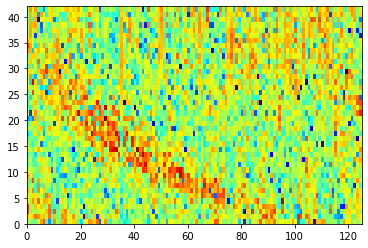

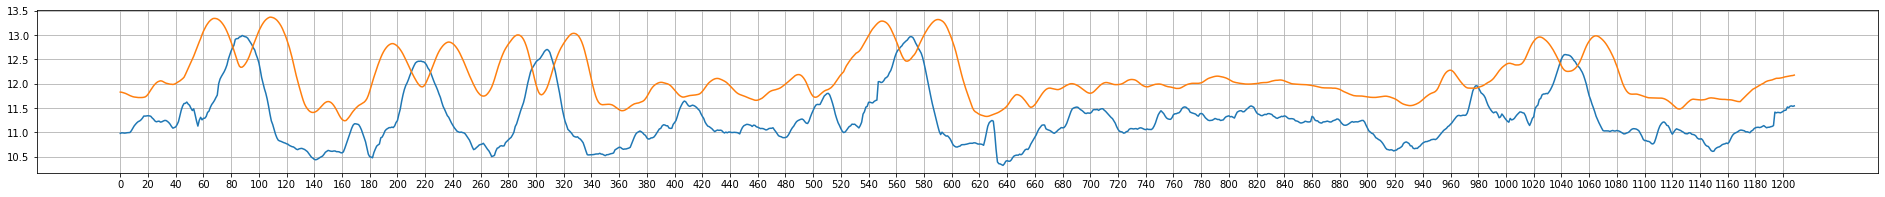

<Figure size 2376x216 with 0 Axes>

['2013-07-07UT14:34:37.06211914.marion.vr2'
 array([[array([ 0.98524393, 10.55500212]), 0],
       [array([ 1.80414798, 10.65964756]), 0],
       [array([ 2.36714451, 10.68555896]), 0],
       [array([ 4.0561341 , 10.74693371]), 0],
       [array([ 6.67278844, 10.96707806]), 0],
       [array([ 7.10143353, 11.20418639]), 0],
       [array([  1.08688, 124.     ]), -1],
       [array([  4.13288, 218.     ]), -1]], dtype=object)
 array([2, 6, 0])]


In [70]:
# my_sample.spectrogram_with_axis()
# freq_slice = [2.5,9]
# kernel = my_sample.whistler_sim(decay=3, whistler_time=0.8, whistler_freq_len=9, whistler_freq_start=2.5, 
#                                 thickness=1,size=25,freq_slice=freq_slice)
# segments, corr = my_sample.segmented_correlation(['slice','zscore'], [freq_slice,[None]], kernel, mode='valid')
# # segments, corr = my_sample.segmented_correlation(['slice'], [[1.5,10]], kernel, mode='valid')
# # segments, corr = my_sample.segmented_correlation([], [], kernel, mode='valid')
# # segments, corr = my_sample.segmented_correlation(['zscore'], [[None]], kernel, mode='valid')
# # corr = corr.reshape(len(corr))
# print(segments.shape, corr.shape,my_sample.get_spectrogram().shape, kernel.shape)
# i = 350
# plt.figure()
# plt.pcolormesh(segments[i],cmap='jet')
# plt.show()

# detector_params = [10,15,1e-2,0]

# plt.figure(figsize=size)
# detector = my_sample.apply_detector(corr,'tm_cfar', detector_params)
# plt.plot(np.log10(corr[detector[1]]**2))
# plt.plot(np.log10(detector[0]))
# plt.xticks(np.arange(0, len(detector[1]), 20));plt.grid();
# plt.show()
# plt.figure(figsize=size)
# plt.show()

# my_sample.spectrogram_with_axis()
# print(my_sample.evaluate_detector(['slice','zscore'], [freq_slice,[None]],'tm_cfar', detector_params, 
#                                   diff_err=diff_err, time_err=time_err, kernel=kernel, segmented=True))

In [19]:
# kernel = my_database.whistler_mean_full(my_sample,transforms=['zscore'], transforms_params=[[None]], cut_time=0.8, cut_time_split=0.3, cut_freq=20,cut_freq_split=0, time_err=0.3)
# for d in [0.5,1,2,3,4,5,6]:
#     for l in [5,6,7,8,9,10,11,12]:
#         for s in [25,50,90,100]:
#             sim = my_sample.whistler_sim(decay=d, whistler_time=0.8, whistler_freq_len=l, whistler_freq_start=2.5, thickness=1,size=s)
#             print(d,l,s,np.log10(signal.correlate(kernel,sim,mode='valid')))
# # print(kernel.shape, sim.shape)

/home/othniel/wdml/data/databases/awdEvents1/marion/marion_h5/['zscore']_[[None]]_[0.8, 0.3, 20, 0, 0.3]_False/train
samples:  1471


100%|██████████| 1471/1471 [00:02<00:00, 714.35it/s]


0.5 5 25 [[6.78651424]]
0.5 5 50 [[6.49928372]]
0.5 5 90 [[6.25311237]]
0.5 5 100 [[6.20709069]]
0.5 6 25 [[6.67660405]]
0.5 6 50 [[6.38624857]]
0.5 6 90 [[6.13765013]]
0.5 6 100 [[6.09429665]]
0.5 7 25 [[6.58836458]]
0.5 7 50 [[6.2933145]]
0.5 7 90 [[6.05577116]]
0.5 7 100 [[6.00563726]]
0.5 8 25 [[6.56798192]]
0.5 8 50 [[6.26980698]]
0.5 8 90 [[6.02168747]]
0.5 8 100 [[5.97991216]]
0.5 9 25 [[6.59477319]]
0.5 9 50 [[6.30031866]]
0.5 9 90 [[6.05554745]]
0.5 9 100 [[6.01265891]]
0.5 10 25 [[6.62010104]]
0.5 10 50 [[6.31993372]]
0.5 10 90 [[6.07412078]]
0.5 10 100 [[6.03052277]]
0.5 11 25 [[6.6616431]]
0.5 11 50 [[6.36392538]]
0.5 11 90 [[6.1124779]]
0.5 11 100 [[6.0651182]]
0.5 12 25 [[6.70222209]]
0.5 12 50 [[6.40204712]]
0.5 12 90 [[6.1481833]]
0.5 12 100 [[6.10764792]]
1 5 25 [[6.9811847]]
1 5 50 [[6.69414291]]
1 5 90 [[6.45472343]]
1 5 100 [[6.40787557]]
1 6 25 [[6.85098761]]
1 6 50 [[6.57078431]]
1 6 90 [[6.32927841]]
1 6 100 [[6.28592741]]
1 7 25 [[6.72518642]]
1 7 50 [[6.4298274

In [73]:
# errors in detection
# 2013-07-02UT15:03:58.44451914.marion.vr2
# 2013-07-02UT16:30:40.82531914.marion.vr2
# 2013-05-20UT15:19:54.09342156.marion.vr2
# 2013-07-03UT15:11:30.48931914.marion.vr2
# 2013-07-19UT01:16:49.26051914.marion.vr2
# 2013-07-25UT15:06:06.85411922.marion.vr2
# 2013-08-04UT00:13:33.08771922.marion.vr2
# 2013-05-18UT13:21:49.81672156.marion.vr2
# 2013-07-04UT15:44:24.35171922.marion.vr2
# 2013-05-28UT13:48:16.34892156.marion.vr2
# 2013-07-07UT13:12:42.47651914.marion.vr2


# samples = ['2013-09-02UT16:17:50.19059414.marion.vr2','2013-07-07UT05:19:49.99651922.marion.vr2','2013-06-28UT04:03:12.85091922.marion.vr2',
#             '2013-10-08UT01:58:59.23379430.marion.vr2','2013-11-09UT22:50:37.90899422.marion.vr2','2013-07-11UT04:36:24.27491938.marion.vr2',
#             '2013-07-25UT04:30:47.73731922.marion.vr2','2013-08-04UT21:34:56.49251922.marion.vr2','2013-02-24UT15:04:07.65347602.marion.vr2',
#             '2013-07-02UT16:10:39.77571914.marion.vr2']
# samples_whistlers_coor = [[[2.2,2.9],[2.9,3.6]],[[2.2,2.9],[5.3,6],[5.8,6.4]],[[2.5,3.2],[4.9,5.5],[6.5,7.2]],
#                           [[2.3,2.6]],[[2.3,2.6],[2.6,3.5]],[[1.2,1.6],[2.3,2.6]],
#                           [[1.8,2.4],[2.4,3.3]],[[2,3]],[[2.3,2.6]],
#                           [[2,3.2],[3.4,3.6],[5.5,6]]]
# samples_whistlers_coor_loc = [[[345,365],[425,455]],[[345,365],[765,855],[865,885]],[[325,395],[725,795],[985,1045]],
#                               [[335,405]],[[45,85],[335,355],[405,445]],[[175,195],[345,355]],
#                               [[265,295],[315,385]],[[325,355]],[[325,375]],
#                               [[285,365],[495,515],[805,855]]]
# samples_whistlers_coor_loc_ = [[[280,520]],[[300,440],[700,960]],[[240,460],[640,880],[940,1100]],
#                               [[260,460]],[[0,140],[240,500]],[[120,240],[280,420]],
#                               [[200,420]],[[180,460]],[[240,420]],
#                               [[220,440],[780,900]]]

# my_sample = Detector(dataset_loc, site, np.random.choice(samples,1)[0])
# my_sample = Detector(dataset_loc, site, samples[8])